# 2. Load Data, Summary

In [86]:
!conda install -c plotly plotly==3.10.0 --yes
!conda install -c conda-forge fbprophet --yes
from fbprophet import Prophet
Prophet()

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: / ^C
failed

CondaError: KeyboardInterrupt



In [87]:
!conda install seaborn=0.9.0 --yes

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet
from fbprophet import Prophet
plt.style.use('ggplot')

In [129]:
path = "prophet_train.csv.csv"
train = pd.read_csv(path)
train.head()

,date,country,province,confirmed
0,1/22/2020,1,1,2
1,1/22/2020,2,1,2
2,1/22/2020,3,1,0
3,1/22/2020,4,1,0
4,1/22/2020,5,1,0


In [130]:
train.shape

(23426, 4)

In [131]:
train["year"] = pd.to_datetime(train["date"]).dt.year
train["month"] = pd.to_datetime(train["date"]).dt.month
train["month_year"] = pd.to_datetime(train["date"]).dt.to_period('M')
train.head()

,date,country,province,confirmed,year,month,month_year
0,1/22/2020,1,1,2,2020,1,2020-01
1,1/22/2020,2,1,2,2020,1,2020-01
2,1/22/2020,3,1,0,2020,1,2020-01
3,1/22/2020,4,1,0,2020,1,2020-01
4,1/22/2020,5,1,0,2020,1,2020-01


# 3. Missing Values

In [132]:
# train.count() will give a value only if not nan
count_nan = len(train) - train.count()
count_nan

date          0
country       0
province      0
confirmed     0
year          0
month         0
month_year    0
dtype: int64

# 4. Individual Feature Visualization

# 4.1 Histogram of daily covid-19 cases

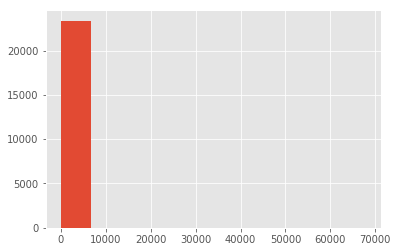

In [133]:
plt.hist(train["confirmed"])
plt.show()

 # 4.2 Increase in number of cases by date and change of increase in cases

In [134]:
mean_confirmed = train.groupby(["date"], as_index=False)
mean_confirmed = mean_confirmed[["confirmed"]].mean()
mean_confirmed["idx"] = mean_confirmed.index

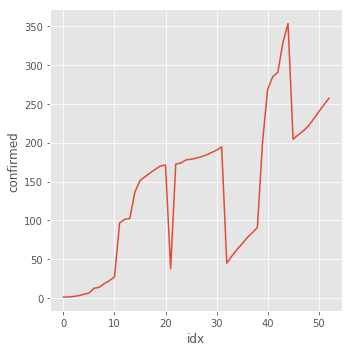

In [135]:
import seaborn as sns
g = sns.relplot(x="idx", y="confirmed", data=mean_confirmed, kind="line")


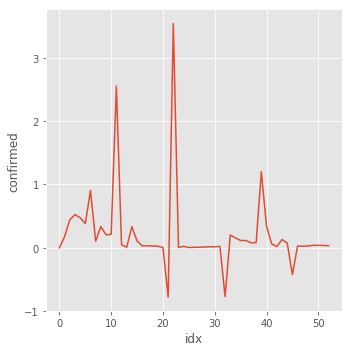

In [136]:
#Change in rate of cases
rt = pd.Series(mean_confirmed["confirmed"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="confirmed", x="idx", data=rt, kind="line")

# 4.3 Increase in cases monthly

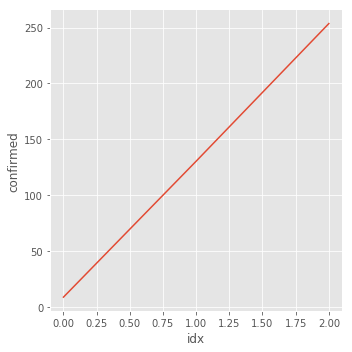

In [137]:
mean_confirmed_monthly = train.groupby(["month_year"], as_index=False)
mean_confirmed_monthly = mean_confirmed_monthly[["confirmed"]].mean()
mean_confirmed_monthly["idx"] = mean_confirmed_monthly.index
g = sns.relplot(y="confirmed", x="idx", data=mean_confirmed_monthly, kind="line")

# 4.4 Increase in Cases by country

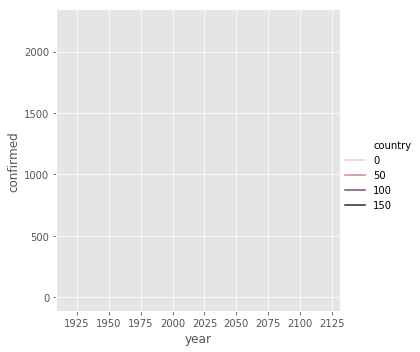

In [139]:
data = train.groupby(['country',"year"])
mean = data[["confirmed"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="confirmed", x="year", data=mean, kind="line", hue="country")


# 5. Prophet Model

# Building the model for country=5(USA)

In [140]:
import warnings
warnings.filterwarnings('ignore')

In [155]:
s1i1 = train[(train["country"]==15)]
s1i1["confirmed"] = np.log1p(s1i1["confirmed"])
s1i1.head()

,ds,country,item,confirmed,y,m,my
16,1/22/2020,15,1,0.0,2020,1,2020-01
458,1/23/2020,15,1,0.0,2020,1,2020-01
900,1/24/2020,15,1,0.0,2020,1,2020-01
1342,1/25/2020,15,1,0.0,2020,1,2020-01
1784,1/26/2020,15,1,0.0,2020,1,2020-01


In [156]:
stats = s1i1[["date", "confirmed"]]
stats.columns = ["ds", "y"]
stats.head()

KeyError: "['date'] not in index"

In [ ]:
m = Prophet()
m.fit(stats)
future = m.make_future_dataframe(periods=365)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
pd.plotting.register_matplotlib_converters()
fig1 = m.plot(forecast)


In [ ]:
fig2 = m.plot_components(forecast)

SMAPE Calcuation

In [ ]:
ps1i1 = forecast[["ds"]]
ps1i1["forecast"] = np.expm1(forecast["yhat"])
ps1i1["yearmonth"] = pd.to_datetime(ps1i1["ds"]).dt.to_period("M")
ps1i1.head()

In [ ]:
def smape(outsample, forecast):
    num = np.abs(outsample-forecast)
    denom = np.abs(outsample) + np.abs(forecast)
    return (num/denom)/2

stats["ds"] = pd.to_datetime(stats["ds"])

In [ ]:
ps1i1["ds"] = pd.to_datetime(ps1i1["ds"])

In [ ]:
train_predict = stats.merge(ps1i1)

In [ ]:
smape_err = smape(train_predict["y"], train_predict["forecast"])
smape_err = smape_err[~np.isnan(smape_err)]
np.mean(smape_err)

# Automated forecasting with Prophet

In [ ]:
train["confirmed"] = np.log1p(train["confirmed"]) 
train["confirmed"] = np.log1p(train["confirmed"])
train.columns = ["ds", "country", "item", "confirmed", "y", "m", "my"]
train.head() 

In [ ]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)


In [ ]:
df = train[(train["country"]==91)]
df = df[["ds", "confirmed"]]
df.columns = ["ds", "y"]
df.head()